<a href="https://colab.research.google.com/github/asilkoc/Complete-Python-3-Bootcamp/blob/master/DNN3_legion_local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#%%
import math
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.nn import functional as F

from numba import jit, prange

In [ ]:
data_1 = pd.read_csv('/content/drive/My Drive/data/test_K_6_Pt_40_debug_1.csv', header=None).values
data_2 = pd.read_csv('/content/drive/My Drive/data/test_K_6_Pt_40_debug_2.csv', header=None).values
data_3 = pd.read_csv('/content/drive/My Drive/data/test_K_6_Pt_40_i7_cpu_conflict.csv',error_bad_lines=False,header=None).values
data_4 = pd.read_csv('/content/drive/My Drive/data/test_K_6_Pt_40_AMD.csv',header=None).values
data_5 = pd.read_csv('/content/drive/My Drive/data/test_K_6_Pt_40_AMD_2.csv',header=None).values

data_1_array = np.array(data_1)
data_2_array = np.array(data_2)
data_3_array = np.array(data_3)
data_4_array = np.array(data_4)
data_5_array = np.array(data_5)

# get rid of the speical five user cases (due to the construction of the csv file)
data_1_array = data_1_array[6:69999]
data_2_array = data_2_array[6:69999]
data_3_array = data_3_array[6:23179,:37]
data_4_array = data_4_array[6:139999]
data_5_array = data_5_array[6:69999]

del data_1
del data_2
del data_3
del data_4
del data_5

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#%% replace all 'i' with 'j'
for row in range(len(data_5_array)):
    for colomn in range(len(data_5_array[1,:])):
        if type(data_5_array[row][colomn]) == str:
            data_5_array[row][colomn] = data_5_array[row][colomn].replace('i','j')

for row in range(len(data_4_array)):
    for colomn in range(len(data_4_array[1,:])):
        if type(data_4_array[row][colomn]) == str:
            data_4_array[row][colomn] = data_4_array[row][colomn].replace('i','j')   

del row
del colomn
            
#%%
#concatenate two array into one
data_total_array_1 = np.concatenate((data_1_array,data_2_array),axis=0)
data_total_array_2 = np.concatenate((data_3_array,data_4_array),axis=0)
data_total_array_3 = np.concatenate((data_total_array_1,data_total_array_2),axis=0)
data_total_array = np.concatenate((data_total_array_3,data_5_array), axis=0)

del data_total_array_1
del data_total_array_2
del data_total_array_3

del data_1_array
del data_2_array
del data_3_array
del data_4_array
del data_5_array


#start = torch.cuda.Event(enable_timing=True)
#end = torch.cuda.Event(enable_timing=True)

#%% dataset perprocessing
# checking if data is not following the format (i.e. not 7 rows as a cluster dataset)
x_list = []
x_temp = 0.0
y_list = []
cluster_start_ind = 0
cluster_end_ind = 0
prev_nan_ind = 0
cluster_length = 0
isNanStartBoolean = False
isNanNextBoolean = False
for i in range(data_total_array.shape[0]):
    if pd.isna(data_total_array[i][36]):
        cluster_end_ind = i
        prev_nan_ind = i
        cluster_length = cluster_end_ind - cluster_start_ind
        if cluster_length == 6:
            x_list.append(data_total_array[cluster_start_ind:cluster_end_ind,:36].tolist())
            y_list.append(data_total_array[cluster_start_ind:cluster_end_ind,36].tolist())
        cluster_start_ind = i+1
    
# transfer all complex number str to complex and seperate them into real and complex numbers
for m in range(len(x_list)):
    for n in range(6):
        for h in range(36):
            
            if x_list[m][n][h].count('j') > 1 or x_list[m][n][h].count('e') > 2:
                #print(x_list[m][n][h])
                x_list[m][n][h] = '0'
            
            x_temp = complex(x_list[m][n][h]).imag
            x_list[m][n][h] = complex(x_list[m][n][h]).real
            x_list[m][n].append(x_temp)
            
for m in range(len(y_list)):
    for n in range(6):
        y_list[m][n] = complex(y_list[m][n]).real

y_array = np.array(y_list)
x_array = np.array(x_list)        


del x_list
del y_list

data_tensor_final_train = torch.utils.data.TensorDataset(torch.Tensor(x_array), torch.Tensor(y_array))

del x_array
del y_array
del data_total_array
del m, n, h, i, isNanNextBoolean, isNanStartBoolean, cluster_end_ind, cluster_length, cluster_start_ind, prev_nan_ind, x_temp
    
#%% data spliting 
'''
DNN_trainset 
DNN_valset
DNN_testset
'''
DNN_trainset, DNN_valset = torch.utils.data.random_split(data_tensor_final_train, lengths=[int(len(data_tensor_final_train)*0.9), len(data_tensor_final_train)-int(len(data_tensor_final_train)*0.9)])
train_data = torch.utils.data.DataLoader(DNN_trainset, batch_size=10, shuffle=True)
val_data = torch.utils.data.DataLoader(DNN_valset, batch_size=10, shuffle=False)

del DNN_trainset
del DNN_valset


#%% constructing the model
class DNN(nn.Module):
    def __init__(self, n_in, n_hidden_1, n_hidden_2, n_hidden_3):
        super(DNN, self).__init__() # nitialing the super class 
        # n_in is the number of input, n_out is the number of output
        self.layer1 = nn.Linear(n_in, n_hidden_1) # fully connectted neural network 
        self.layer2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.layer3 = nn.Linear(n_hidden_2, n_hidden_3)
        self.layer4 = nn.Linear(n_hidden_3, 6) 
    
    # self.layer1(x) -> wx+b 
    # torch.relu() -> activition
    # self.layer2() -> wx+b 
    #'''
    #def forward(self, x):
     #   return self.layer4(self.sigmoid(self.layer3(torch.relu(self.layer2(torch.relu(self.layer1(x)))))))
    #'''
    def forward(self,x):
        return torch.sigmoid(self.layer4(torch.sigmoid(self.layer3(torch.sigmoid(self.layer2(torch.sigmoid(self.layer1(x))))))))
    
    
    #def sigmoid(x):
     #  return 1 / (1+torch.exp(x))
    
#%%
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cpu


In [ ]:
#%% defining loss functions
#####################################################################################################
#                                       log cosh loss                                               #
#####################################################################################################
def logcosh(pred, true):
    loss = torch.log(torch.cosh(true - pred))
    return torch.sum(loss)


#%%
#####################################################################################################
#                                       sum_rate_loss with tensor                                   #
#####################################################################################################
@jit
def Sum_rate_loss_tensor(H_eff_tensor,P_label_tensor,P_pred_tensor,NoisePower,P_t,alpha):
    #SUM_RATE_valid_list = []
    #SUM_RATE_pred_list = []
    temp_tensor_valid = torch.empty(1).to(device)
    temp_tensor_valid_check = temp_tensor_valid
    temp_tensor_pred = torch.empty(1).to(device)
    temp_tensor_pred_check = temp_tensor_pred
    for rows in prange(len(H_eff_tensor)):
            H_eff = H_eff_tensor[rows,:,36:72].type(torch.complex64)*1j+H_eff_tensor[rows,:,:36]
            P_label = P_label_tensor[rows]
            P_pred = P_pred_tensor[rows]
            #------------------------------------ initialization -----------------------------------------#
            # initialization
            K               = torch.tensor(len(H_eff)).to(device)            # number of rows 
            NRF             = torch.tensor(len(H_eff[0])).to(device)          # number of columns
            P_opt           = torch.diagflat(P_label);
            P_pred          = torch.diagflat(P_pred);
            
            #------------------------------------ P_label start -----------------------------------------#
            # calculate BB precoder for P_label
            # there was a sum on NRF (sum(NRF))
            W               = torch.linalg.pinv(torch.matmul(torch.transpose(torch.conj(H_eff),0,1),H_eff) + K*alpha*(torch.eye(torch.sum(NRF)).to(device)))
            B               = torch.matmul(W,torch.transpose(torch.conj(H_eff),0,1))
            Eps             = torch.sqrt(P_t/diag_sum(torch.matmul(torch.matmul(B,P_opt) ,(torch.transpose(torch.conj(torch.matmul(B,P_opt)),0,1)))))                       
            B_All           = torch.matmul(Eps*B,P_opt)
            
             
            # calculate sum rate for P_label
            H_all           = torch.matmul(H_eff,B_All)
            GAIN            = torch.square(torch.abs((H_all))) 
            SIGNAL          = torch.diag(GAIN)
            SIGNAL          = SIGNAL.reshape(len(P_pred),1)
            INTERF          = torch.sum(GAIN-torch.diagflat(torch.diag(GAIN)),axis=1)
            SUM_RATE_valid  = torch.sum(torch.log2(1+SIGNAL/(INTERF + NoisePower).reshape(len(P_pred),1)))
            #SUM_RATE_valid_list.append(SUM_RATE_valid)
            if (temp_tensor_valid == temp_tensor_valid_check)[0]:
                temp_tensor_valid = SUM_RATE_valid
                temp_tensor_valid = temp_tensor_valid.reshape(1)
            else:
                temp_tensor_valid = torch.cat((temp_tensor_valid.to(device),SUM_RATE_valid.reshape(1)),0)
            #------------------------------------ P_pred start -----------------------------------------#
            
            # calculate sun rate for P_pred
            W               = torch.linalg.pinv(torch.matmul(torch.transpose(torch.conj(H_eff),0,1),H_eff) + K*alpha*(torch.eye(torch.sum(NRF)).to(device)))
            B               = torch.matmul(W,torch.transpose(torch.conj(H_eff),0,1))
            Eps             = torch.sqrt(P_t/diag_sum(torch.matmul(torch.matmul(B,P_pred) ,(torch.transpose(torch.conj(torch.matmul(B,P_pred)),0,1))))+ 1e-8) + 1e-14                          
            B_All           = torch.matmul(Eps*B,P_pred)
            
            
            # Calculate Sum-Rate for P_pred
            H_all           = torch.matmul(H_eff,B_All)
            GAIN            = torch.square(torch.abs((H_all)))
            SIGNAL          = torch.diag(GAIN).reshape(len(P_pred),1)
            INTERF          = torch.sum(GAIN-torch.diagflat(torch.diag(GAIN)),axis=1)
            SUM_RATE_pred  = torch.sum(torch.log2(1+SIGNAL/(INTERF + NoisePower).reshape(len(P_pred),1)))
            #SUM_RATE_pred_list.append(SUM_RATE_pred)
            if (temp_tensor_pred == temp_tensor_pred_check)[0]:
                temp_tensor_pred = SUM_RATE_pred
                temp_tensor_pred = temp_tensor_pred.reshape(1)
            else: 
                temp_tensor_pred = torch.cat((temp_tensor_pred.to(device),SUM_RATE_pred.reshape(1)),0)
            
    #--------------------------------- sum rate loss start -------------------------------------#
    
    # Calculate Loss
    #LOSS = SUM_RATE_valid - SUM_RATE_pred;
    #LOSS = nn.MSELoss(SUM_RATE_valid,SUM_RATE_pred)
    return temp_tensor_valid.to(device), temp_tensor_pred.to(device)
    
    
    
def db2pow(ydb):
    y = 10**(ydb/10)
    return y
    
def diag_sum(H):
    for i in range(len(H)):
        if i == 0:
            sum_temp = H[i][i]
        if i > 0:
            sum_temp += H[i][i]
    return sum_temp    


In [ ]:
#%%
model = DNN(n_in=6*72, n_hidden_1=512, n_hidden_2=1024, n_hidden_3 =512).to(device)
loss_func = nn.MSELoss()
#loss_func = nn.L1Loss()
#loss_func = nn.SmoothL1Loss(beta=1.0)
#loss_func = logcosh()
val_loss_func = nn.MSELoss()
#val_loss_func = nn.L1Loss(reduction='sum')
#val_loss_func = nn.SmoothL1Loss(reduction='sum',beta=1.0)
#val_loss_func = logcosh()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0000001)

In [ ]:
#%%
'''
trainning loop
'''
#torch.autograd.set_detect_anomaly(False)
counter = 0
n_epoch = 100
model = model.to(device)
y_hat_max = []
y_max = []
batch_loss_all = []
val_loss_all = []
batch_loss_min = 100
NoisePower_dBm  = -134;
NoisePower      = torch.tensor(db2pow(NoisePower_dBm - 30)).to(device);
P_t_dBm         = 40;
P_t             = torch.tensor(db2pow(P_t_dBm - 30)).to(device);
alpha           = torch.tensor(NoisePower/P_t).to(device);
#start.record()
for epoch in range(n_epoch): 
    batch_loss_accum = 0
    model.train()
    for x, y in train_data: 
        # remember to to(device first)
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        '''
        print("---------------model -------------------")
        print(model.state_dict())
        '''
        y_hat = model(x.view(-1, 6*72))
        '''
        print("--------------y_hat---------------")
        print(y_hat)
        '''
        [SUM_RATE_valid, SUM_RATE_pred] = Sum_rate_loss_tensor(x, y.type(torch.complex64), y_hat.type(torch.complex64),NoisePower,P_t,alpha)
        '''
        print("-------------- Sum rate pred -------------")
        print(SUM_RATE_pred)
        '''
        batch_loss = loss_func(SUM_RATE_valid,SUM_RATE_pred)+ 1e-14 
        batch_loss_all.append(batch_loss.cpu().detach().numpy())
        '''
        print("-------------- batch loss --------------")
        print(batch_loss)
        '''
        #batch_loss_all.append(batch_loss)
        batch_loss.backward() # autodiff
        '''
        print("-----------------------------------------------------------")
        print("layer 1 weight gradient: " + str(model.layer1.weight.grad))
        print("Layer 1 bias gradident: "+ str(model.layer1.bias.grad))
        print("layer 2 weight gradient: " + str(model.layer2.weight.grad))
        print("Layer 2 bias gradident: "+ str(model.layer2.bias.grad))
        print("layer 3 weight gradient: " + str(model.layer3.weight.grad))
        print("Layer 3 bias gradident: "+ str(model.layer3.bias.grad))
        print("layer 4 weight gradient: " + str(model.layer4.weight.grad))
        print("Layer 4 bias gradident: "+ str(model.layer4.bias.grad))
        '''
        counter += 1
        optimizer.step()
    
      


    model.eval() # signal evaluation phase
    with torch.no_grad():
        val_loss = 0
        val_count = 0
        for x, y in val_data:
            x, y = x.to(device), y.to(device) # move the data to cuda
            y_hat = model(x.view(-1,6*72)) # resize the size of the x, -1 depends on the batch size
            # initialization
            [SUM_RATE_valid, SUM_RATE_pred] = Sum_rate_loss_tensor(x, y.type(torch.complex64), y_hat.type(torch.complex64),NoisePower,P_t,alpha)
            val_loss += val_loss_func(SUM_RATE_pred,SUM_RATE_valid)
            val_count += 1
        val_loss = val_loss/val_count
        val_loss_all.append(val_loss.cpu().detach().numpy())

    # finding the optimal output
    if len(y_hat_max) == 0:
      y_hat_max = y_hat
      val_loss_min = val_loss
      y_max = y
    if len(y_hat_max) > 0:
      if val_loss < val_loss_min:
        y_hat_max = y_hat
        val_loss_min = val_loss
        y_max = y
    #PATH = "optimal_model_epoch_"+ str(epoch) + ".pt"
    #torch.save(model,PATH)

    print("-----------%d\tbatch-loss: %.4f\tval-loss: %.4f"%(epoch, batch_loss, val_loss))
#end.record()
# Waits for everything to finish running
#torch.cuda.synchronize()

#print("time used: {}".format(start.elapsed_time(end))) # time here is in ms 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
<ipython-input-37-a0bf00e11f4d>:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "Sum_rate_loss_tensor" failed type inference due to: Untyped global name 'diag_sum': cannot determine Numba type of <class 'function'>

File "<ipython-input-37-a0bf00e11f4d>", line 38:
def Sum_rate_loss_tensor(H_eff_tensor,P_label_tensor,P_pred_tensor,NoisePower,P_t,alpha):
    <source elided>
            B               = torch.matmul(W,torch.transpose(torch.conj(H_eff),0,1))
            Eps             = torch.sqrt(P_t/diag_sum(torch.matmul(torch.matmul(B,P_opt) ,(torch.transpose(torch.conj(torch.matmul(B,P_opt)),0,1)))))                       
            ^

  @jit
<ipython-input-37-a0bf00e11f

-----------0	batch-loss: 23.3080	val-loss: 1587.0752
-----------1	batch-loss: 20.6919	val-loss: 844.1158
-----------2	batch-loss: 5.1165	val-loss: 351.9540
-----------3	batch-loss: 140.3604	val-loss: 278.8418
-----------4	batch-loss: 2.6908	val-loss: 254.0633
-----------5	batch-loss: 75.6562	val-loss: 235.2030
-----------6	batch-loss: 34.8061	val-loss: 223.9452
-----------7	batch-loss: 268.6542	val-loss: 220.3216
-----------8	batch-loss: 293.5082	val-loss: 219.3692
-----------9	batch-loss: 67.2894	val-loss: 219.1282
-----------10	batch-loss: 0.0319	val-loss: 219.0375
-----------11	batch-loss: 440.9828	val-loss: 218.6526
-----------12	batch-loss: 4.2648	val-loss: 218.4372
-----------13	batch-loss: 57.8415	val-loss: 217.9315
-----------14	batch-loss: 2283.8210	val-loss: 217.3084
-----------15	batch-loss: 0.5373	val-loss: 216.4729
-----------16	batch-loss: 14.7188	val-loss: 215.3271
-----------17	batch-loss: 87.7537	val-loss: 213.3332
-----------18	batch-loss: 461.2231	val-loss: 209.7464


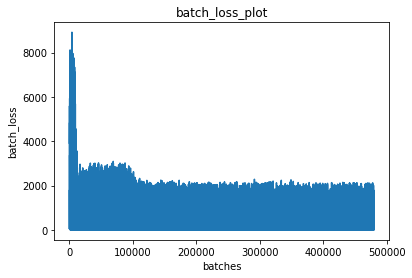

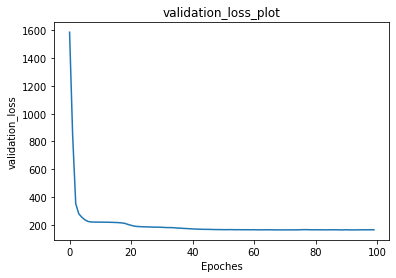

tensor([[1.5788e-04, 4.3809e-04, 7.1028e-03, 5.8109e-07, 6.2011e-07, 6.5016e-03]])
tensor([[0.2161, 0.8314, 0.0143, 0.0086, 0.0119, 0.9999]])
tensor(162.9006)


In [ ]:

#%% print batch loss graph
'''
for items in range(len(batch_loss_all)):
    
    batch_loss_all[items] = batch_loss_all[items].cpu().detach().numpy()
for items in range(len(val_loss_all)):
    val_loss_all[items] = val_loss_all[items].cpu().detach().numpy()
'''
#%%


plt.plot(list(range(len(batch_loss_all))),(batch_loss_all))
plt.xlabel('batches')
plt.ylabel('batch_loss')
plt.title('batch_loss_plot')
plt.show()

plt.plot(list(range(len(val_loss_all))),val_loss_all)
plt.xlabel('Epoches')
plt.ylabel('validation_loss')
plt.title('validation_loss_plot')
plt.show()

#%%
print(y_hat_max)

#%%
print(y_max)
#%%
print(val_loss_min)